In [1]:
import urbs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_style(style="whitegrid")

color_dict = {
    "random": '#0070C0',
    
    #Generation
    'Biomass power plants': '#00B050',
    'Coal power plants': '#7F7F7F',
    'Gas power plants': '#ED7D31',
    'Geothermal power plants': '#385723',
    'Hydro power plants': '#1F4E79',
    'Nuclear power plants': '#BF9000',
    'Oil power plants': '#843C0C',
    'Onshore wind parks': '#9DC3E6',
    'Photovoltaics': '#F4EF11',
    'Others': '#3B3838',
    
    # Consumption
    'Electric chargers': '#0070C0',
    'Electricity (end-use)': '#00B0F0',
    'Process heating 100+ (electric heaters)': '#C55A11',
    'Process heating 100- (heat pumps)': '#BF9000',
    'Process heating 200+ (electric heaters)': '#843C0C',
    'Space heating (heat pumps)': '#548235',
    'Curtailment': '#767171',

    # Storage
    "Elec storage out": '#FFAAA6',
    "Elec storage in": '#FF8C94',
    "Heat A storage in": '#FF8C94',
    "Heat A storage out": '#FFAAA6',
    "Heat B storage in": '#FF8C94',
    "Heat B storage out": '#FFAAA6'
}

In [2]:
# Load data for all years

years = [
         #2025, 
         2030, 
         #2035, 
         2040, 
         #2045, 
         2050]

df = {}
for year in years:
    df[year] = urbs.load(f"myopic/output/output_bayern_{year}.h5")._result

In [3]:
# Check keys for the HDF files
df[years[0]].keys()

dict_keys(['cap_pro', 'cap_pro_new', 'cap_sto_c', 'cap_sto_c_new', 'cap_sto_p', 'cap_sto_p_new', 'com', 'com_buy', 'com_demand', 'com_env', 'com_sell', 'com_stock', 'com_supim', 'com_tuples', 'com_type', 'cost_type', 'costs', 'def_costs', 'def_initial_storage_state', 'def_intermittent_supply', 'def_partial_process_input', 'def_partial_process_output', 'def_process_input', 'def_process_output', 'def_storage_energy_power_ratio', 'def_storage_state', 'dt', 'e_co_buy', 'e_co_sell', 'e_co_stock', 'e_pro_in', 'e_pro_out', 'e_sto_con', 'e_sto_in', 'e_sto_out', 'obj', 'pro', 'pro_area_tuples', 'pro_input_tuples', 'pro_maxgrad_tuples', 'pro_output_tuples', 'pro_partial_input_tuples', 'pro_partial_output_tuples', 'pro_partial_tuples', 'pro_timevar_output_tuples', 'pro_tuples', 'res_area', 'res_buy_step', 'res_buy_total', 'res_env_step', 'res_env_total', 'res_global_co2_limit', 'res_process_capacity', 'res_process_maxgrad_lower', 'res_process_maxgrad_upper', 'res_process_throughput_by_capacity', 

In [4]:
def dual_plots():

    co2_duals = {}
    for year in years:    
        co2_duals[f"{year}_co2_dual"] = df[year]["res_global_co2_limit"]

    pd.DataFrame(co2_duals).plot.bar(legend = None)
    plt.title("Duals of the CO2 limit in €/t")

    df[year]["res_process_capacity"].reset_index().set_index('pro').drop(['stf', 'sit'], axis = 1).plot.barh(legend = None)
    plt.title(f"Duals of power plant contraints in {year} in €/MW")

    df[year]["res_storage_capacity"].reset_index().set_index('sto').drop(['stf', 'sit'], axis = 1).plot.barh(legend = None)
    plt.title(f"Duals of storage contraints in {year} in €/MWh")
#dual_plot()

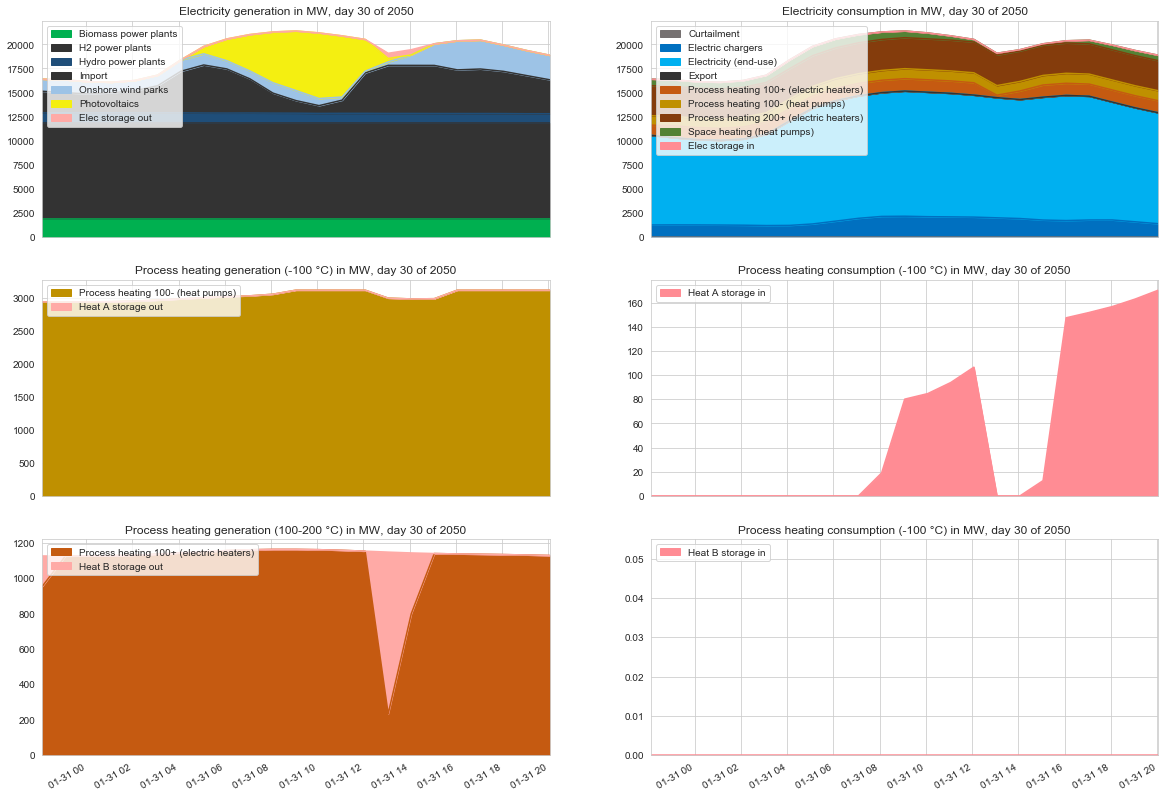

In [9]:
year = 2050
day = 30

def dayplot():

        # Electricity storage in and output
        sto_in = (df[year]['e_sto_in']
                .unstack()['Elec']
                .unstack()
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                .sum(axis = 1)
                )
                
        sto_out = (df[year]['e_sto_out']
                .unstack()['Elec']
                .unstack()
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                .sum(axis = 1))

        sto_out.name = "Elec storage out"
        sto_in.name = "Elec storage in"

        # Heat storage A in and output
        sto_in_phA = (df[year]['e_sto_in']
                .unstack()['Process heating A']
                .unstack()
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                .sum(axis = 1))
        sto_out_phA = (df[year]['e_sto_out']
                .unstack()['Process heating A']
                .unstack()
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                .sum(axis = 1))

        sto_out_phA.name = "Heat A storage out"
        sto_in_phA.name = "Heat A storage in"


        # Heat storage B in and output
        sto_in_phB = (df[year]['e_sto_in']
                .unstack()['Process heating B']
                .unstack()
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                .sum(axis = 1))
        sto_out_phB = (df[year]['e_sto_out']
                .unstack()['Process heating B']
                .unstack()
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                .sum(axis = 1))

        sto_out_phB.name = "Heat B storage out"
        sto_in_phB.name = "Heat B storage in"

        # Electricity generation
        gen = (df[year]['e_pro_out']
                .unstack()['Elec']
                .dropna()
                .unstack()
                .replace(0, np.nan).dropna(axis = 1, how = "all")
                .replace(np.nan, 0)
                .reorder_levels(['stf', 'sit', 't'])
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                )


        # Electricity consumption
        con = (df[year]['e_pro_in']
                .unstack()['Elec']
                .dropna()
                .unstack()
                .replace(0, np.nan).dropna(axis = 1, how = "all")
                .replace(np.nan, 0)
                .reorder_levels(['stf', 'sit', 't'])
                .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                )


        # Process heating A consumption
        con_phA = (df[year]['e_pro_out']
        .unstack()['Process heating A']
        .dropna()
        .unstack()
        .reorder_levels(['stf', 'sit', 't'])
        .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
        )


        # Process heating B consumption
        con_phB = (df[year]['e_pro_out']
        .unstack()['Process heating B']
        .dropna()
        .unstack()
        .reorder_levels(['stf', 'sit', 't'])
        .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
        )


        # Create case-study plot for electricity

        fig, axes = plt.subplots(3, 2, figsize = (20, 15), sharex = True)


        gen.join(pd.DataFrame(sto_out)).iloc[0 + day*24 : 23 + day*24, :].plot(ax = axes[0,0], kind = "area", color = [color_dict.get(x, '#333333') for x in (gen.join(pd.DataFrame(sto_out))).columns])
        axes[0,0].set_title(f"Electricity generation in MW, day {day} of {year}")
        axes[0,0].legend(loc = "upper left")

        con.join(pd.DataFrame(sto_in)).iloc[0 + day*24 : 23 + day*24, :].plot(ax = axes[0,1], kind = "area", color = [color_dict.get(x, '#333333') for x in (con.join(pd.DataFrame(sto_in))).columns])
        axes[0,1].set_title(f"Electricity consumption in MW, day {day} of {year}")
        axes[0,1].legend(loc = "upper left")


        con_phA.join(pd.DataFrame(sto_out_phA)).iloc[0 + day*24 : 23 + day*24, :].plot(ax = axes[1,0], kind = "area", color = [color_dict.get(x, '#333333') for x in (con_phA.join(pd.DataFrame(sto_out_phA))).columns])
        axes[1,0].set_title(f"Process heating generation (-100 °C) in MW, day {day} of {year}")
        axes[1,0].legend(loc = "upper left")

        (pd.DataFrame(sto_in_phA)).iloc[0 + day*24 : 23 + day*24, :].plot(ax = axes[1,1], kind = "area", color = [color_dict.get(x, '#333333') for x in (pd.DataFrame(sto_in_phA)).columns])
        axes[1,1].set_title(f"Process heating consumption (-100 °C) in MW, day {day} of {year}")
        axes[1,1].legend(loc = "upper left")


        con_phB.join(pd.DataFrame(sto_out_phB)).iloc[0 + day*24 : 23 + day*24, :].plot(ax = axes[2,0], kind = "area", color = [color_dict.get(x, '#333333') for x in con_phB.join(pd.DataFrame(sto_out_phB)).columns])
        axes[2,0].set_title(f"Process heating generation (100-200 °C) in MW, day {day} of {year}")
        axes[2,0].legend(loc = "upper left")

        (pd.DataFrame(sto_in_phB)).iloc[0 + day*24 : 23 + day*24, :].plot(ax = axes[2,1], kind = "area", color = [color_dict.get(x, '#333333') for x in (pd.DataFrame(sto_in_phB)).columns])
        axes[2,1].set_title(f"Process heating consumption (-100 °C) in MW, day {day} of {year}")
        axes[2,1].legend(loc = "upper left")

dayplot()

In [6]:
def fourier_plots():

    def fourier_plot(data, comm, tech):
    
        # Convert storage level data
        df = (data['e_sto_con']
        .unstack()[comm]
        .dropna()
        .unstack()
        .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8761))
        )
        
        # Calculate SOC, and de-mean the timeseries data
        soc = (df[tech] - np.mean(df[tech])) / np.max(df[tech])
        n = len(soc)
        # Calculate FFT vector, power density vector, and frequency
        fhat = np.fft.fft(soc, n)
        PSD = fhat * np.conj(fhat) / n
        freq = (1/n) * np.arange(n)

        # Create a pairplot with the modified SOC and FFT components
        fig, axs = plt.subplots(2, 1)

        plt.sca(axs[0])
        plt.plot(soc)

        plt.sca(axs[1])
        plt.plot(freq[0:200], PSD[0:200])

        plt.suptitle(f"Seasonality of {tech}")

    fourier_plot(df[year], 'Process heating A', 'Process heat storage A')
    fourier_plot(df[year], 'Process heating B', 'Process heat storage B')
    fourier_plot(df[year], 'Space heating', 'Space heating storage')
    fourier_plot(df[year], 'Elec', 'Pump storage')
    fourier_plot(df[year], 'Elec', 'Battery')

#fourier_plots()

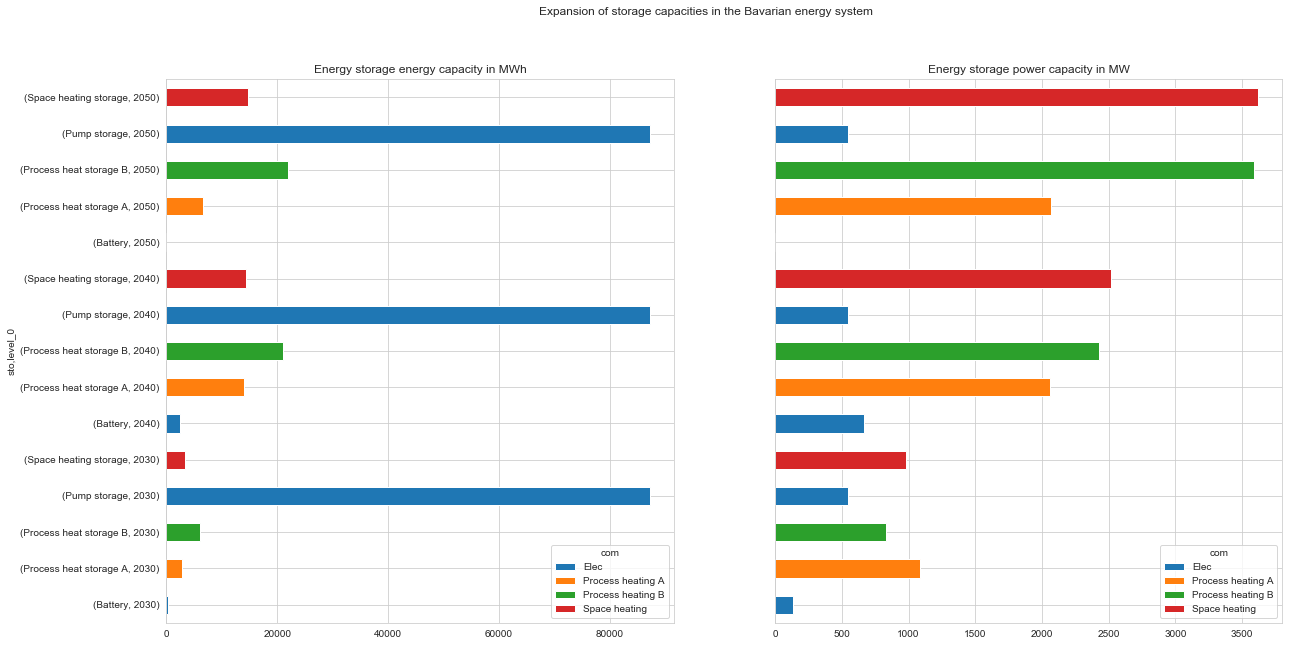

In [7]:
def storage_plot():

    sto_c_y = {}
    sto_p_y = {}

    for year in years:
        sto_c_y[year] = df[year]['cap_sto_c'].unstack()
        sto_p_y[year] = df[year]['cap_sto_p'].unstack()

    fig, axes = plt.subplots(1, 2, figsize = (20, 10), sharey=True)

    pd.concat(sto_c_y).reset_index().set_index(['sto', 'level_0']).drop(['stf', 'sit'], axis = 1).plot(ax = axes[0], kind = 'barh', stacked = True)
    axes[0].set_title("Energy storage energy capacity in MWh")

    pd.concat(sto_p_y).reset_index().set_index(['sto', 'level_0']).drop(['stf', 'sit'], axis = 1).plot(ax = axes[1], kind = 'barh', stacked = True)
    axes[1].set_title("Energy storage power capacity in MW")

    fig.suptitle("Expansion of storage capacities in the Bavarian energy system")

storage_plot()

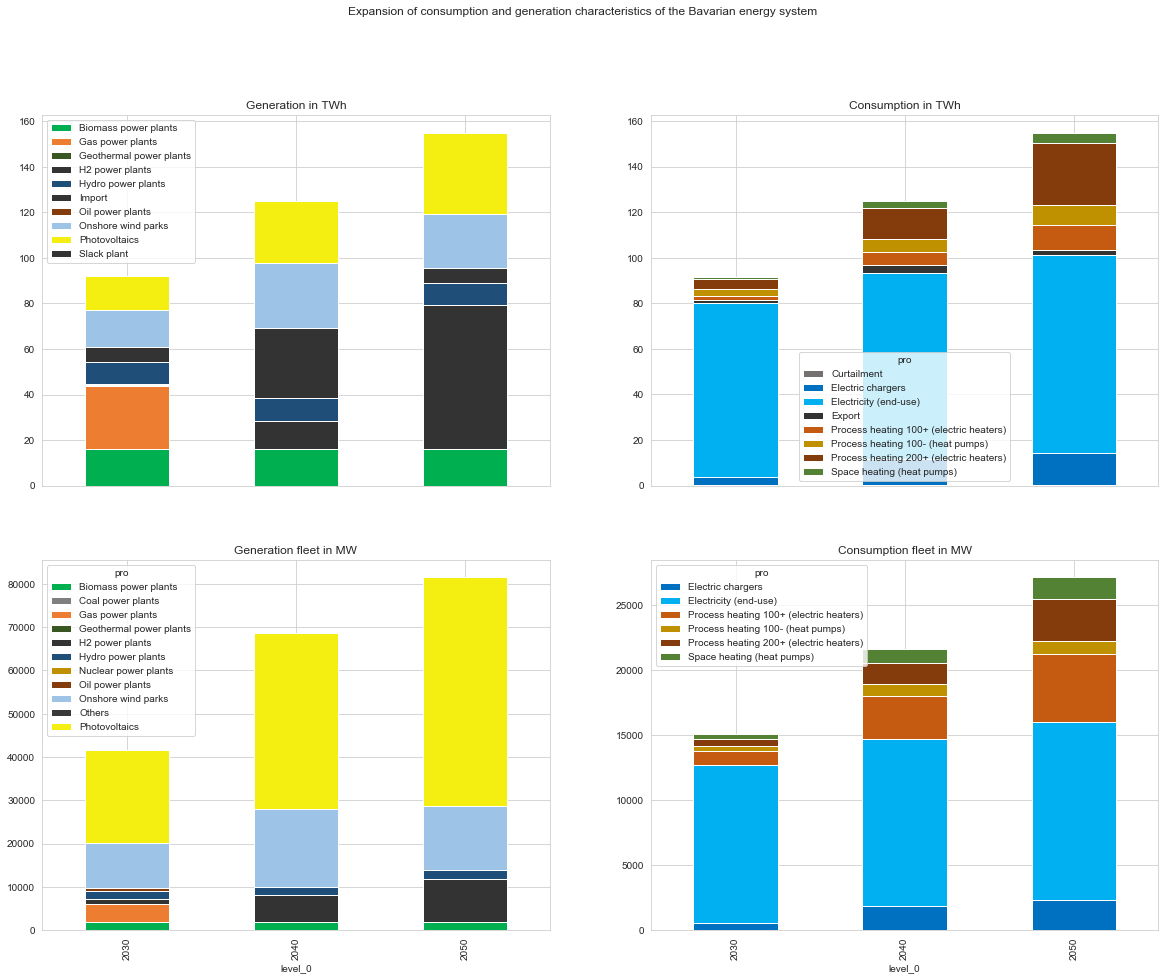

In [8]:
def energy_plot():

    # Creating dataframes for the list of processes

    gen = (df[years[-1]]['e_pro_out']
    .unstack()['Elec']
    .dropna()
    .unstack()
    )

    con = (df[years[-1]]['e_pro_in']
        .unstack()['Elec']
        .dropna()
        .unstack()
        )
    
    fig, axes = plt.subplots(2, 2, figsize = (20,15), sharex = True)

    gen_y = {}

    for year in years:
        gen_y[year] = (df[year]['e_pro_out']
            .unstack()['Elec']
            .dropna()
            .unstack()
            .replace(0, np.nan).dropna(axis = 1, how = "all")
            .replace(np.nan, 0)
            .reorder_levels(['stf', 'sit', 't'])
            .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
            .resample('Y').sum()
            )
        
    to_plot = ((pd.concat(gen_y, sort = True) / 1e6)
    .reset_index()
    .set_index('level_0')
    .drop(['level_1'], axis = 1)
    )
    to_plot.plot(ax = axes[0,0], kind = 'bar', stacked = 'True', color = [color_dict.get(x, '#333333') for x in to_plot.columns])
    axes[0, 0].set_title("Generation in TWh")

    con_y = {}

    for year in years:
        con_y[year] = (df[year]['e_pro_in']
            .unstack()['Elec']
            .dropna()
            .unstack()
            .replace(0, np.nan).dropna(axis = 1, how = "all")
            .replace(np.nan, 0)
            .reorder_levels(['stf', 'sit', 't'])
            .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
            .resample('Y').sum()
            )
        
    to_plot = ((pd.concat(con_y, sort = True) / 1e6)
    .reset_index()
    .set_index('level_0')
    .drop(['level_1'], axis = 1)
    )
    to_plot.plot(ax = axes[0,1], kind = 'bar', stacked = 'True', color = [color_dict.get(x, '#333333') for x in to_plot.columns])
    axes[0, 1].set_title("Consumption in TWh")



    gen_cap_y = {}
    con_cap_y = {}

    for year in years:
        gen_cap_y[year] = df[year]['cap_pro'].unstack()[gen.columns].drop(['Curtailment', 'Slack plant', 'Import'], axis = 1)
        con_cap_y[year] = df[year]['cap_pro'].unstack()[con.columns].drop(['Curtailment', 'Export'], axis = 1)

    to_plot = (pd.concat(gen_cap_y, sort = True)
    .reset_index()
    .drop(['stf', 'sit'], axis = 1)
    .set_index('level_0')
    )
    to_plot.plot(ax = axes[1, 0], kind = 'bar', stacked = True, color = [color_dict.get(x, '#333333') for x in to_plot.columns])
    axes[1, 0].set_title("Generation fleet in MW")


    to_plot = (pd.concat(con_cap_y, sort = True)
    .reset_index()
    .drop(['stf', 'sit'], axis = 1)
    .set_index('level_0')
    )
    to_plot.plot(ax = axes[1,1], kind = 'bar', stacked = True, color = [color_dict.get(x, '#333333') for x in to_plot.columns])
    axes[1, 1].set_title("Consumption fleet in MW")

    fig.suptitle("Expansion of consumption and generation characteristics of the Bavarian energy system")

energy_plot()